In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('sap_storing_data_hu_project.csv')

C:\Users\emiel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe

In [4]:
def get_accuracy(r,zip_list):

    return len([ _ for x in zip_list if x[0]+r >= x[1] >= x[0]-r])/len(zip_list)

<h2>Data Cleaning </h2>

In [5]:
# ik zorg er hier voor dat de 'stm_progfh_in_duur' kolom naar floats gecast wordt
df.stm_progfh_in_duur = df.stm_progfh_in_duur.apply(lambda x: float(str(x).replace('-','').replace('*','').strip()))

# delete stm_fh_duur outliers
#df = column_outlier('a', df.copy(), ['stm_fh_duur'])


# voeg dummy kolommen voor seizoenen toe
df.stm_sap_melddatum = pd.to_datetime(df.stm_sap_melddatum)

df['date_offset'] = (df.stm_sap_melddatum.dt.month*100 + df.stm_sap_melddatum.dt.day - 320)%1300

df['seizoen_melding'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

df.drop(['date_offset'], axis=1)
df = df.join(pd.get_dummies(df.seizoen_melding))

# join de oorzaakcodes
o_df = pd.read_csv('Oorzaakcodes.csv', sep = ';')
o_df = o_df.rename(columns={'Code': 'stm_oorz_code'})
df = df.merge(o_df, on = 'stm_oorz_code', how = 'outer')



# maak target var bins zodat we classification kunnen gebruiken
error_margin  = 10
bins = [x for x in range(0,900,error_margin)]
labels = [x for x in range(1,len(bins))]
df['duration_bin'] = pd.cut(df['stm_fh_duur'], bins = bins, labels=labels)


# we willen alleen durations die niet gelijk zijn aan 0 en kleiner zijn dan 8 uur
df = df[(df.stm_fh_duur != 0) & (df.duration_bin <= 48)]


In [6]:
pd.set_option('display.max_rows', None)

In [7]:
pd.set_option('display.max_columns', None)

<AxesSubplot:xlabel='stm_fh_duur', ylabel='Density'>

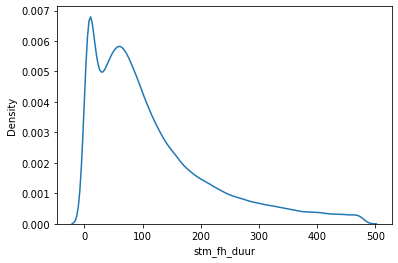

In [8]:
sns.kdeplot(df.stm_fh_duur)

<h2> MODEL COMPARISON </h2>

In [9]:
df_co = df.copy()
#df_co = df_co[df_co.Oorzaak == 'IJsafzetting/ijzel']

In [10]:
df_co = df_co[['stm_reactie_duur', 'Oorzaak','stm_equipm_nr_mld', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_km_van_mld','stm_fh_duur', 'stm_progfh_in_duur','duration_bin', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']].sample(frac = 1)

In [11]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

dt_df = df_co.copy()[['duration_bin', 'stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_km_van_mld','spring', 'summer','autumn','winter']].dropna()

X = dt_df.drop(columns = ['duration_bin'])
y = dt_df['duration_bin']


X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2)

#c = GridSearchCV(DecisionTreeClassifier(), {'max_depth' : [i for i in range(1,200)]})
#clf = c.fit(X_train_dt, y_train_dt)

clf = DecisionTreeClassifier(max_depth = 84, random_state = 0).fit(X_train_dt, y_train_dt)
y_pred_dt = clf.predict(X_test_dt)

accuracy_score(y_test_dt,y_pred_dt)

0.5599503578726637

In [12]:
kn_df = df[['duration_bin','stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']].dropna()
X = kn_df.drop(columns = ['duration_bin'])
y = kn_df.duration_bin

X_train_kn, X_test_kn, y_train_kn, y_test_kn = train_test_split(X, y, test_size=0.2)

clf2 = KNeighborsClassifier(n_neighbors = 1).fit(X_train_kn, y_train_kn)

y_pred_kn = clf2.predict(X_test_kn)
accuracy_score(y_test_kn,y_pred_kn)

0.5534776235971285

In [13]:
bins = [x for x in range(0,900,error_margin)]
labels = [x for x in range(1,len(bins))]
prog_df = df_co.copy()[['stm_progfh_in_duur','duration_bin']]
prog_df = column_outlier('a', prog_df.copy(), ['stm_progfh_in_duur'])
prog_df['prog_duration_bin'] = pd.cut(prog_df['stm_progfh_in_duur'], bins = bins, labels=labels)
prog_df = prog_df.dropna()
prog_df = prog_df[['duration_bin', 'prog_duration_bin']]

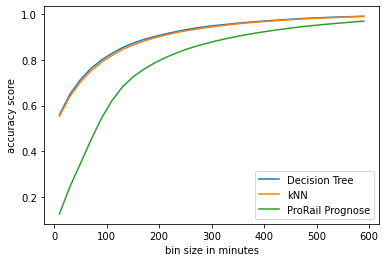

In [14]:
x_ax = [error_margin +(20*x) for x in range(0,30)]

y1_ax = [get_accuracy(x, list(zip(list(y_test_dt), y_pred_dt))) for x in range(0,30)]
y2_ax = [get_accuracy(x, list(zip(list(y_test_kn), y_pred_kn))) for x in range(0,30)]


X = df_co['Oorzaak']
y = df_co['duration_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


y3_ax = [get_accuracy(x, list(zip(list(prog_df.duration_bin), list(prog_df.prog_duration_bin)))) for x in range(0,30)]


plt.plot(x_ax,y1_ax, label = 'Decision Tree')
plt.plot(x_ax,y2_ax, label = 'kNN')
plt.plot(x_ax,y3_ax, label = 'ProRail Prognose')



plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()

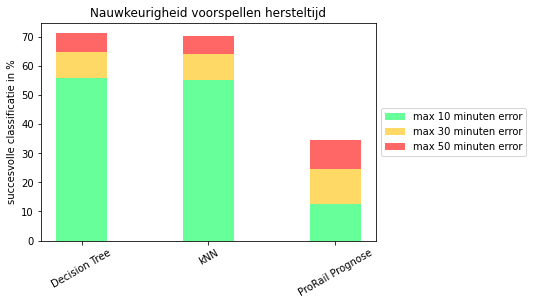

In [15]:
labels = ['Decision Tree', 'kNN', 'ProRail Prognose']

min_10 = [100 * eval(f"y{i}_ax[0]") for i in range(1,len(labels)+1)]
min_30 = [100 * (eval(f"y{i}_ax[1]") - eval(f"y{i}_ax[0]")) for i in range(1,len(labels)+1)]
min_50 = [100 * (eval(f"y{i}_ax[2]") - eval(f"y{i}_ax[1]")) for i in range(1,len(labels)+1)]

width = 0.4  

fig, ax = plt.subplots()

ax.bar(labels, min_10, width, label='max 10 minuten error', color = '#66ff99')
ax.bar(labels, min_30, width ,bottom=min_10,label='max 30 minuten error', color = '#ffd966')
ax.bar(labels, min_50, width ,bottom=(np.array(min_30) + np.array(min_10)),label='max 50 minuten error', color = '#ff6666')


ax.set_ylabel('succesvolle classificatie in %')
ax.set_title('Nauwkeurigheid voorspellen hersteltijd')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=30)

plt.show()

In [16]:
list(X_train_dt.columns)

['stm_equipm_nr_mld',
 'stm_reactie_duur',
 'stm_prioriteit',
 'stm_km_tot_mld',
 'stm_km_van_mld',
 'spring',
 'summer',
 'autumn',
 'winter']

In [17]:
list(X_train_kn.columns)

['stm_equipm_nr_mld',
 'stm_reactie_duur',
 'stm_prioriteit',
 'stm_km_tot_mld',
 'stm_rapportage_jaar',
 'spring',
 'summer',
 'autumn',
 'winter']

In [23]:
# base chance for a right classification by guessing the most common bin
max(df.duration_bin.dropna().value_counts())/len(df.duration_bin.dropna())

0.08928084097409525